# Analysing airline profitability in FY 2022/23

The aviation industry was hit severely by COVID-19 in 2020 and 2021, with demand falling to about a third of what it was pre-pandemic. The industry has long since recovered, but this recovery has not been equal - some airlines still struggle to return to pre-pandemic profit levels, while others have bounced back much faster. My goal was to investigate the factors that help explain these differences and to identify what set the airlines that recovered fast apart from those that didn't.


#### SOME QUESTIONS YOU MAY HAVE

- **Why FY2022/23?**

  Given that I was investigating airline performance during the *recovery* from the pandemic, and global restrictions were mostly lifted by mid-2022, I felt that 2022/23 was the period that best fit the *recovery* phase. Most of the world was still in lockdown in 2021, and 2024 would probably fall into the *post-recovery* phase.

  ASIDE: Due to different accounting standards globally, financial years differ between the airlines in the dataset. For airlines reporting from 1st July to 31st June, I used their 2022/23 annual report. For airlines reporting for the calendar year, I used their 2022 annual report.

- **Measure of profitability?**

  **Earnings before interest and taxes (EBIT)**. This was an obvious choice; EBIT isolates the *operational* profitability of a company, removing the effects of financing costs and taxation which are less relevant to this study. I felt that EBITDA (earnings before interest, taxes, depreciation, and amortisation) would have been too optimistic in this context -  depreciation and amortisation are meaningful expenses in a capital-intensive industry like aviation.

- **Currency?**

  EBIT was measured in USD. For airlines that reported in other currencies and did not include USD figures in their annual reports, I converted figures to USD using the spot exchange rate on the final day of the reporting period as reported by [Wise](https://wise.com/gb/currency-converter/).

#### DATA AND SAMPLING

Due to the limited availability of data of this kind online, I collected the data manually, relying on airlines' annual reports. 

Number of observations: **100**

Number of predictors: **9** 

I selected predictors to capture specific aspects of each airline:

- **airline** information: `airline_age`, `low_cost_carrier` (*Y* if the airline is a low-cost carrier, *N* if not)
- **fleet** data: `avg_fleet_age`, `fleet_size`, `aircraft_utilisation`
- **capacity** data: `ask` (Available Seat Kilometres - total carrying capacity), `num_routes`
- **demand/usage** data: `passenger_yield` (revenue per paying passenger per kilometre flown), `load_factor` (proportion of available seats filled by a customer)



This data was **not sampled randomly**. I used a stratified, purposive sampling approach where I sampled by region to ensure balanced regional representation. The process was as follows:

- I first determined the proportion of airlines from each region: Africa, Asia Pacific, Europe, Latin America, the Middle East, and North America. (*stratified*)
- Then I chose the **major** airlines within each region, those being the airlines most likely to be publicly traded and therefore more likely to publish annual reports. (*purposive*)

Non-random sampling makes the findings in this study less generalisable to the general population of airlines. However, as this is primarily an exploratory study, I prioritised the availability of data over generalisability.

#### FOR NON-TECHNICAL READERS

The following sections are quite technical - if you'd prefer to skip directly to the results, [click here](#Results).

## Table of Contents

1. [Imports](#Imports)
2. [Dealing with Missing Values](#Dealing-with-Missing-Values)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA))
4. [Feature Engineering](#Feature-Engineering)
5. [Model Building](#Model-Building)
6. [Model Evaluation](#Model-Evaluation)
7. [Results](#Results)

## Imports

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [39]:
data = pd.read_csv('airline_data.csv')

In [40]:
data.head()

,iata_code,airline_name,region,functional_currency,ebit_usd,load_factor,low_cost_carrier,airline_age,num_routes,passenger_yield,ask,avg_fleet_age,fleet_size,aircraft_utilisation
0,ET,Ethiopian Airlines,Africa,ETB,1.032027e+09,0.703,N,78.0,136.0,0.107,6.449871e+10,8.80,154.0,NaN
1,KQ,Kenya Airways,Africa,KES,7.600000e+07,0.784,N,47.0,42.0,0.111,1.480400e+10,13.50,40.0,NaN
2,LA,LATAM Airlines,Latin America,USD,1.078165e+09,0.831,N,95.0,148.0,0.090,1.370000e+11,11.48,333.0,NaN
3,AV,Avianca,Latin America,USD,6.185440e+08,0.824,N,104.0,147.0,0.083,5.470600e+10,9.30,140.0,NaN
4,AD,Azul Brazilian Airlines,Latin America,BRL,5.968403e+08,0.804,Y,15.0,160.0,0.101,4.400600e+10,7.40,183.0,10.0


## Dealing with Missing Values

During the collection phase, it became apparent that airline annual reports were not standardised - they didn't all contain the variables I was interested in. However, in some regions, such as North America, annual reports had all the key metrics (such as load factor, ASMs, yield) in one section, likely due to regulatory requirements. 

A more serious issue occurd when I was unable to find data on **any** of the numeric variables of interest. This frequently occurred for airlines that were part of larger airline groups, such as Air France-KLM group and IAG. Privately-owned airlines were also less likely to publish comprehensive annual reports. However, I was able to get the categorical `low_cost_carrier` variable for all airlines.

To get the number of observations with NO (numeric) variables at all (both predictors and response):

In [41]:
# get list of predictor columns
response = ['ebit_usd']
predictors = ['load_factor', 'low_cost_carrier', 'airline_age', 'num_routes', 'passenger_yield', 'ask', 'avg_fleet_age', 'fleet_size', 'aircraft_utilisation']
numeric_predictors = [pred for pred in predictors if pred != 'low_cost_carrier']

# get number of observations where all predictor and response values are missing
data[response + numeric_predictors].isnull().all(axis=1).sum()


27

There were 27 observations for which I was unable to get any data. These airlines were:

In [42]:
str(list(data[data[response + numeric_predictors].isnull().all(axis=1)]['airline_name']))

"['Boliviana de Aviacion', 'Flybondi', 'Saudia', 'Iberia', 'Air France', 'Condor', 'Bulgaria Air', 'Air Malta', 'ITA Airways', 'HiSky', 'Flair', 'Aeromexico', 'Porter Airlines', 'Endeavour Air', 'Silver Airways', 'Avelo Airlines', 'Air Inuit', 'Calm Air', 'Air India', 'Air Niugini', 'Jetstar', 'Malaysian Airlines', 'Hainan Airlines', 'PIA', 'Lion Air', 'Spring Airlines', 'Air Japan']"

#### GROUP-BASED IMPUTATION


Note that the **27** airlines that have no numeric data are either privately owned, or part of larger conglomerates.

There's a **complication**: because these 27 observations have no response values (EBIT) or predictor values, they will not be of much use in this study.

Matrix completion will not work in this case because the missingness does not depend on the observed data - there isn't any data for the missingness to depend on. Additionally, I cannot simply drop these observations because the sample would cease to be representative of the regions. In light of these considerations, my strategy is to perform **group-based mean imputation** on the **predictor** values, based on `region`. Once I have built a regression model, I will impute the EBIT values of these airlines based on these values.

In [43]:
all_missing = data[response + numeric_predictors].isnull().all(axis=1)
for pred in numeric_predictors:
    region_means = data.groupby('region')[pred].transform('mean')
    all_missing_valid = all_missing & region_means.notna() # impute only for regions that have at least one value of the predictor
    data.loc[all_missing_valid, pred] = region_means[all_missing_valid]

In [44]:
# check how many observations have at least one missing predictor value:
data[numeric_predictors].isnull().any(axis=1).sum()

60

Note that, after handling the observations with no numeric predictor values, we still have 60 observations with at least one value missing. These include observations from the previous step that belonged to regions with no values at all for some predictors - mean-based imputation failed in those cases.

In this context, it is reasonable to assume that this data is **Missing At Random (MAR)**. I'm (reasonably) assuming that the missing data depends on the observed numeric predictors, and missingness does not depend on the unobserved data. The factors most likely to determine missingness (region, country, private vs. publicly traded) are not part of the predictors we're considering. I will thus perform **Matrix Completion** on the numeric predictors.



 

#### MATRIX COMPLETION

**DATA SETUP**: 

Our data matrix is $X \in \mathbb{R}^{100 \times 8}$ where 100 is the **total** number of observations, and **8** is the number of **numeric** predictors.

We can perform a so-called [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) of $X$:

$$
X = U \Sigma V^\top 
$$

**Matrix completion** is a data imputation approach that assumes that the data matrix is low-rank, and thus recovers missing entries using a low-rank *M*-dimensional approximation to the data (using the first *M* [principal components](https://en.wikipedia.org/wiki/Principal_component_analysis)).

After initialising missing entries with mean imputation, we repeat the following until convergence:

1. Compute the SVD of the current filled-in matrix $ \tilde{X}$: $\quad \tilde{X} = U \Sigma V^\top$
2. Compute a rank-M approximation using the first M principal components (this is the **best** rank-*M* approximation): $\quad \hat{\tilde{X}} = U_M \Sigma_M V_M^\top$
3. Update the **missing** entries of the original matrix $X$ to get the next $\tilde{X}$: $\quad \tilde{X}_\text{new} = \begin{cases} [\hat{\tilde{X}}]_\text{ij} & \text{if } (i, j) \notin \text{observed} \\ X_\text{ij} & \text{otherwise}\end{cases}$

Convergence is tested using the "distance" between $X$ and its current rank-M approximation: 

$$
\sum_{(i,j) \in \text{observed}} (X_\text{ij} - [U_M \Sigma_M V_M^\top]_\text{ij})^2
$$


I will now implement the above in code:

In [45]:
X = np.array(data[numeric_predictors])
np.isnan(X).any(axis=1).sum()

60

In [46]:
# initialise missing entries with predictor means
X_filled = X.copy()
missing_idx = np.where(np.isnan(X_filled))
X_filled[missing_idx] = np.take(np.nanmean(X_filled, axis = 0), missing_idx[1])

In [47]:
# a function that computes the "distance" between X and its current rank-M approximation
def compute_objective(X, X_hat):
    objective = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if not np.isnan(X[i,j]):
                objective += (X[i,j] - X_hat[i,j])**2
    return objective

In [48]:
# iterate until convergence
M = 3 # rank of the approximation
tol = 1e-3 # convergence tolerance
old_objective = 0
u, s, vh = None, None, None
while True:
    # compute the rank-M approximation
    u, s, vh = np.linalg.svd(X_filled)
    u, s, vh = u[:,:M], np.diag(s[:M]), vh[:M, :]
    X_hat = u@s@vh
    X_filled = np.where(np.isnan(X), X_hat, X)

    # clip the filled-in values within each column to force them into the range of observed values
    # (if this is not done, some missing values may be filled with values that do not make sense, e.g. negative time)
    for col in range(X.shape[1]):
        observed_mask = ~np.isnan(X[:,col])
        col_observed_vals = X[observed_mask, col]
        X_filled[:,col] = np.clip(X_filled[:,col], col_observed_vals.min(), col_observed_vals.max())

    # check for convergence
    curr_objective = compute_objective(X, X_hat)
    if np.abs(curr_objective - old_objective) < tol:
        break

    old_objective = curr_objective

In [49]:
# after matrix completion is done, we work with the filled-in matrix
X_new = X_filled

Now that we have a filled matrix, we can proceed with statistical analysis.

## Exploratory Data Analysis (EDA)

In [50]:
print('The numeric predictors of interest in this study are:')
y = np.array(data[response]).T[0]
numeric_predictors

The numeric predictors of interest in this study are:


['load_factor',
 'airline_age',
 'num_routes',
 'passenger_yield',
 'ask',
 'avg_fleet_age',
 'fleet_size',
 'aircraft_utilisation']

First, I will create scatter plots of EBIT against some numeric predictors:

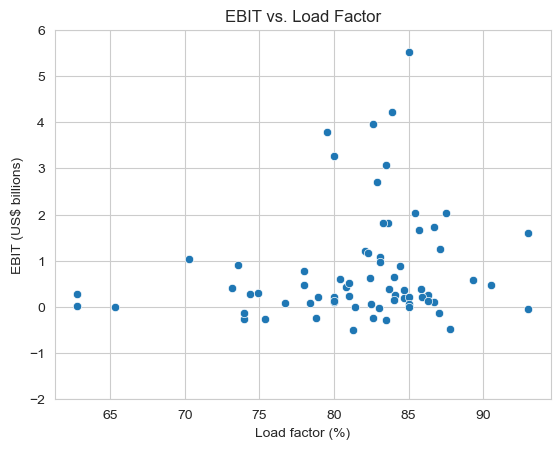

In [51]:
# EBIT against Load Factor
ax = sns.scatterplot(x=X_new[:,0]*100, y=y/1000000000)
ax.set(xlabel='Load factor (%)', ylabel = 'EBIT (US$ billions)', title='EBIT vs. Load Factor', yticks=range(-2,7))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

While the relationship does not seem apparent at first glance, note that the airlines with outlier (above average) EBIT values all had high load factors. Airlines with average EBIT values had a wider spread of load factors.

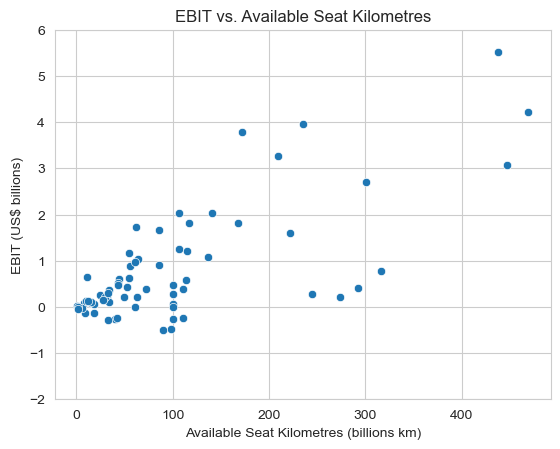

In [52]:
# EBIT against Available Seat Kilometres
ax = sns.scatterplot(x=X_new[:,4]/1000000000, y=y/1000000000)
ax.set(xlabel='Available Seat Kilometres (billions km)', ylabel = 'EBIT (US$ billions)', title='EBIT vs. Available Seat Kilometres', yticks=range(-2,7))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

This relationship is much clearer - airlines with higher capacity (as measured by ASKs) had higher EBIT values on average. It does seem, however, that the ASK values are right skewed - this predictor will need to be *log-transformed* to make its distribution more symmetric.

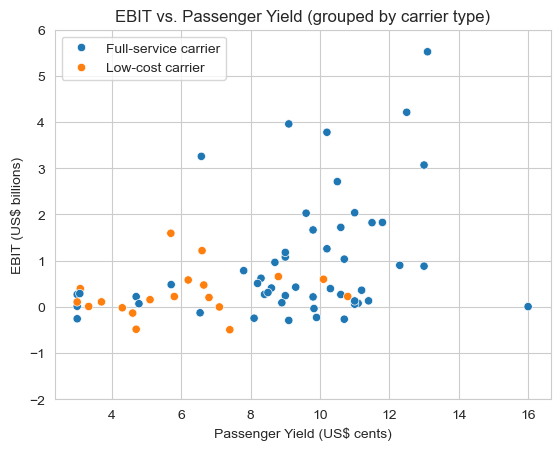

In [53]:
# EBIT against Passenger Yield (grouped by carrier type)
lcc = ["Full-service carrier" if val=="N" else "Low-cost carrier" for val in np.array(data['low_cost_carrier'])]
ax = sns.scatterplot(x=X_new[:,3]*100, y=y/1000000000, \
                     hue=lcc)
ax.set(xlabel='Passenger Yield (US$ cents)', ylabel = 'EBIT (US$ billions)', title='EBIT vs. Passenger Yield (grouped by carrier type)', yticks=range(-2,7))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

As expected, low-cost carriers generally earn less revenue per passenger kilometre. Additionally, on first inspection, it seems that low-cost carriers were generally less profitable than full-service carriers. To explore this further:

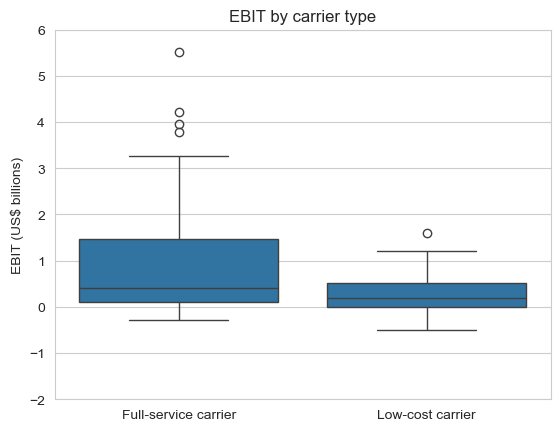

In [54]:
ax = sns.boxplot(x=lcc, y=y/1000000000)
ax.set(ylabel = 'EBIT (US$ billions)', title='EBIT by carrier type', yticks=range(-2,7))
plt.show()

 `aircraft_utilisation` had, by far, the most missing values. I'm interested to in how that matrix completion algorithm handled this:

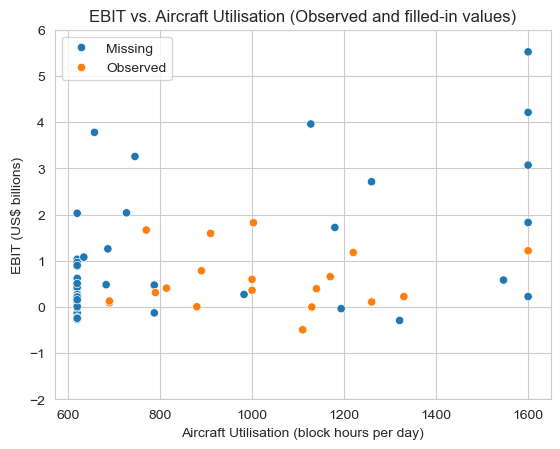

In [55]:
# Aircraft Utilisation
ax = sns.scatterplot(x=X_new[:,7]*100, y=y/1000000000, \
                     hue=["Observed" if not np.isnan(val) else "Missing" for val in X[:,7]])
ax.set(xlabel='Aircraft Utilisation (block hours per day)', ylabel = 'EBIT (US$ billions)', title = 'EBIT vs. Aircraft Utilisation (Observed and filled-in values)', yticks=range(-2,7))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

The effects of *clipping* are noticeable: many filled-in values fall on the boundary of the range of observed values. Other predictors behave similarly.

Finally, I will construct a pairplot to examine the pairwise relationships between predictors. Such a plot helped detect collinearity between predictors.

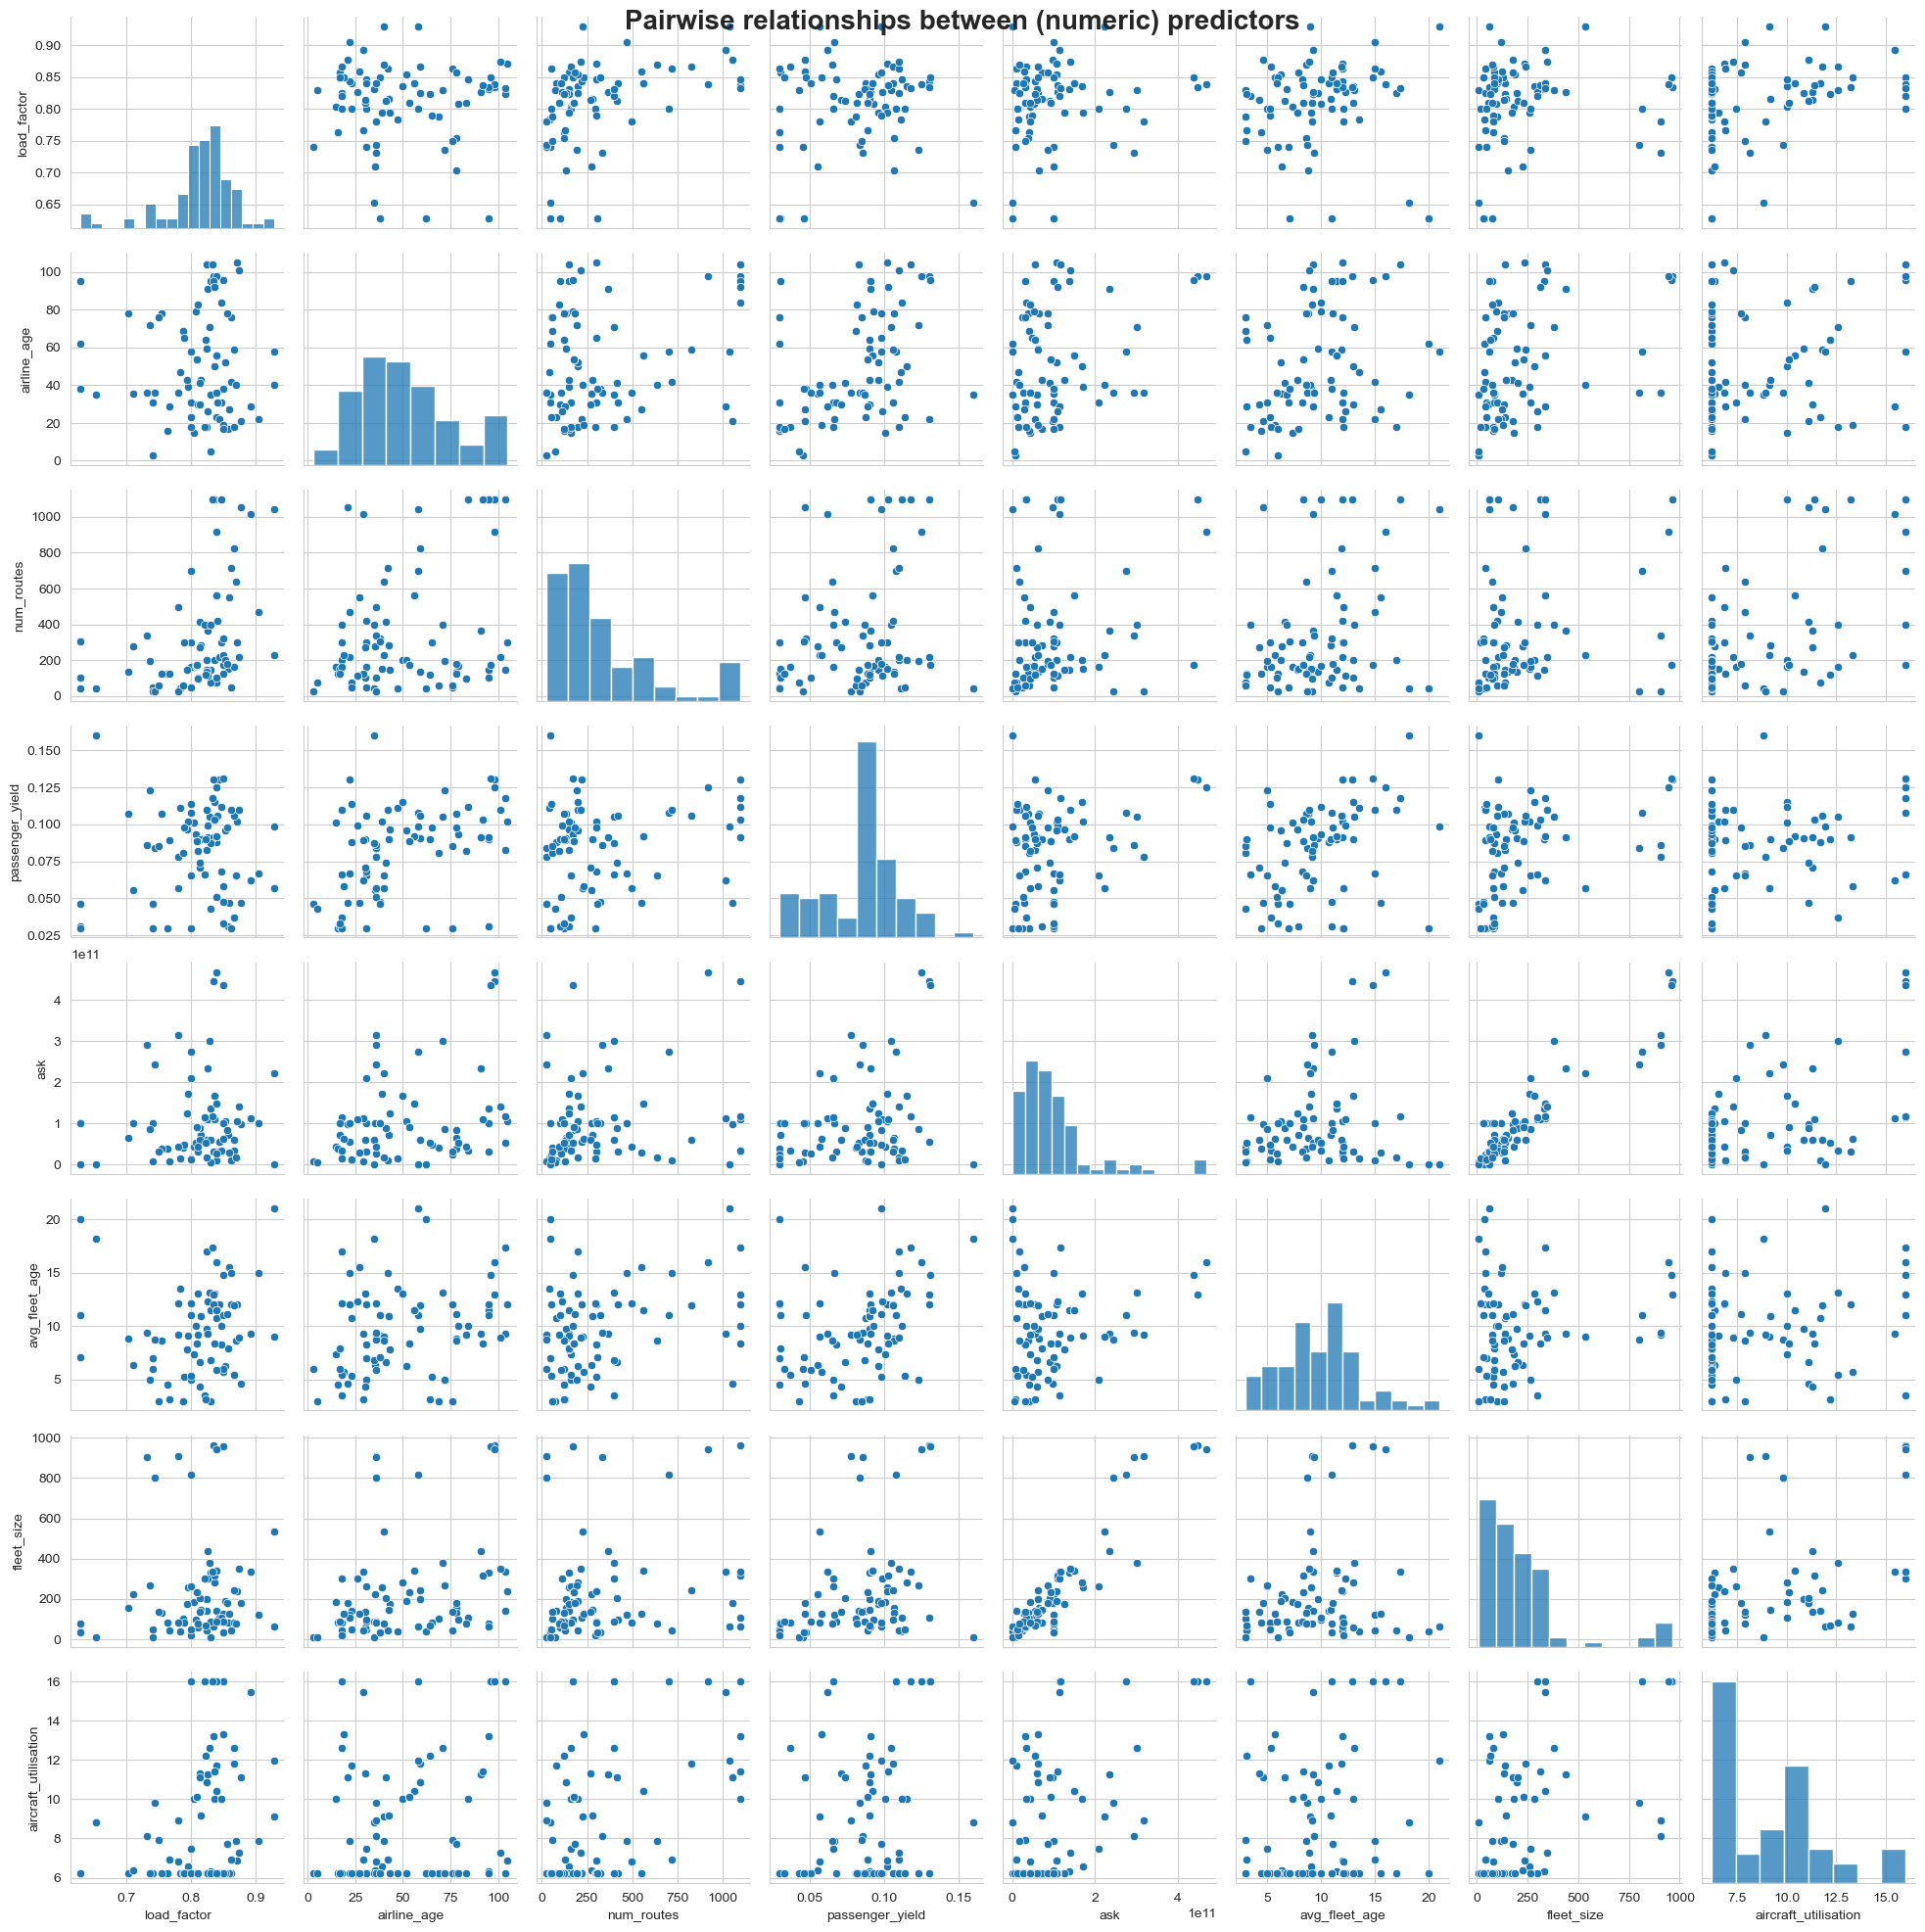

In [56]:
sns.pairplot(data=pd.DataFrame(X_new, columns=numeric_predictors))
plt.suptitle('Pairwise relationships between (numeric) predictors', weight='bold', fontsize=20, y=0.99)
plt.show()

As expected, there was a very strong positive relationship between **Available Seat Kilometres** and **Fleet size**. This is not unexpected - airlines with more planes will generally have higher capacity. The statistical tools used in my analysis rely on the predictor independence assumption, and so I will address the issue of collinearity in the next section.

## Feature Engineering

#### INCLUDING THE CATEGORICAL PREDICTOR `low_cost_carrier` IN THE MATRIX

To encode the categorical predictor `low_cost_carrier` in the data matrix, I appended a dummy column to the data matrix, with **1** denoting that the airline is a low-cost carrier, and **0** indicating otherwise.

In [57]:
# append dummy column to X_obs for low_cost_carrier
dummy_col = np.array([1.0 if val=='Y' else 0.0 for val in data['low_cost_carrier']])
X_new = np.hstack([X_new, dummy_col.reshape(-1,1)])

# update the list of predictor names
numeric_predictors += ['low_cost_carrier']

# create a new matrix with only those observations that have an observed response
observed_ebit = ~np.isnan(y)
X_obs = X_new[observed_ebit]

#### DEALING WITH MULTICOLLINEARITY

I first calculated the **Variance Inflation Factors** (VIFs) of the predictors. 

Conceptually, the variance of the regression coefficient corresponding to the $j^\text{th}$ predictor can be decomposed into the variance, $\sigma^2$, of the error term, the reciprocal of the total sum of squares, and *a third* term:

$$
Var(\hat{\beta}_j) = \sigma^2 \frac{1}{(1-R^2_j)} \frac{1}{\sum^n_\text{i=1} (x_\text{ij} - \bar{x}_j)^2}
$$

where $R^2_j$ is the [$R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination) value obtained when we build a regression model with the $j^\text{th}$ variable as a response, and the other variables as predictors.

Note that $\frac{1}{(1-R^2_j)} \to \infty$ as $R^2_j \to 1$. In other words, if a predictor is highly correlated with the others, the variance of its regression coefficient becomes large. This makes the coefficient unstable. This issue is referred to as **multicollinearity**.

The term $\frac{1}{(1-R^2_j)}$ is known as the *Variance Inflation Factor* of the $j^\text{th}$ predictor - it has the effect of increasing the variance of $\hat{\beta}_j$. We would prefer the variance of this estimate to be as low as possible, which is why it is important that any predictor with an unacceptable *VIF* is detected and dealt with.

In [58]:
def compute_vifs(X):
    vifs = []
    for j in range(X.shape[1]):
        # build a design matrix excluding predictor j, and a response of predictor j
        y_j = X_obs[:,j]
        X_j = np.delete(X, j, axis=1)
        X_j = np.hstack([np.ones((X_j.shape[0],1)), X_j])
    
        # compute the regression coefficient estimate
        beta_hat_j = np.linalg.inv(X_j.T@X_j)@X_j.T@y_j
    
        # compute RSS and TSS
        RSS_j = (y_j - X_j@beta_hat_j).T@(y_j - X_j@beta_hat_j)
        TSS_j = (y_j - np.ones((y_j.shape[0],))*np.mean(y_j))@(y_j - np.ones((y_j.shape[0],))*np.mean(y_j))
    
        # compute VIF_j
        vifs += [TSS_j/RSS_j]
    return vifs

In [59]:
compute_vifs(X_obs)

[1.3916148636831986,
 1.812142408427885,
 2.1451270538213802,
 1.7293862605314627,
 8.280954231644031,
 1.266520802404547,
 8.387549096602006,
 2.8962681345384693,
 2.673288658827392]

As expected, the 5th and 7th predictors (corresponding to `ask` and `fleet_size`) had high VIFS, indicating that they could each be predicted by one or more of the other predictors. This is consistent with the point I raised in the EDA section about the relationship between these two predictors. 

Using these findings, the natural next step was to somehow interact these two predictors

Adding the interaction term `ask * fleet_size` in addition to these two predictors would **not** solve the problem; it would make the problem worse because we'd be simply adding a third predictor that's highly correlated with the two.

A more powerful solution was to create a new predictor that replaces these two predictors: **ASKs per aircraft**. This was calculated as `ask_per_aircraft = ask / fleet_size`. This neatly captures the joint information inherent in these two predictors while eliminating the collinearity because the two predictors are removed from the model.

This new predictor was added to all observations, including the ones with a missing EBIT figure, since these observations must have all the necessary predictors for predicting EBIT with the final model.

In [60]:
# append the new predictor to the data matrix and remove the two old predictors
ask_per_aircraft = X_new[:,4] / X_new[:,6]
X_new = np.delete(X_new, [4,6] , axis=1)
X_new = np.column_stack([X_new, ask_per_aircraft])
X_obs = X_new[observed_ebit]

In [61]:
# update the list of predictors
numeric_predictors = list(np.delete(numeric_predictors, [4,6]))
numeric_predictors += ['ask_per_aircraft']

In [62]:
numeric_predictors

['load_factor',
 'airline_age',
 'num_routes',
 'passenger_yield',
 'avg_fleet_age',
 'aircraft_utilisation',
 'low_cost_carrier',
 'ask_per_aircraft']

Finally, I recomputed the VIFs to see if this transformation had (mostly) eliminated multicollinearity:

In [63]:
compute_vifs(X_obs)

[1.3530346308870604,
 1.7769969853883578,
 2.010070394093818,
 1.9802902621817493,
 1.2693768371024836,
 2.0927628779771985,
 2.6809580007195244,
 1.281642642972683]

All the VIFs were under 5, indicating that the multicollinearity in the dataset was now in an acceptable range and did not warrant any further transformation of predictors.

The relationship between this new predictor and EBIT:

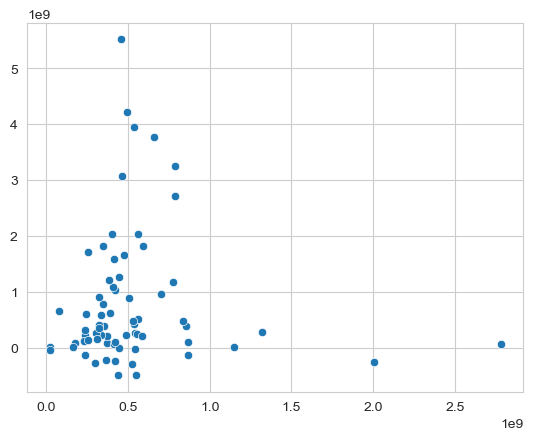

In [64]:
sns.scatterplot(x=X_obs[:,7], y=y[observed_ebit])
plt.show()

#### FURTHER EDA ON MY FINAL SET OF PREDICTORS

Before I began building the model, I examined the relationship between each predictor and the response to determine what transformations (if any) were required for each predictor.

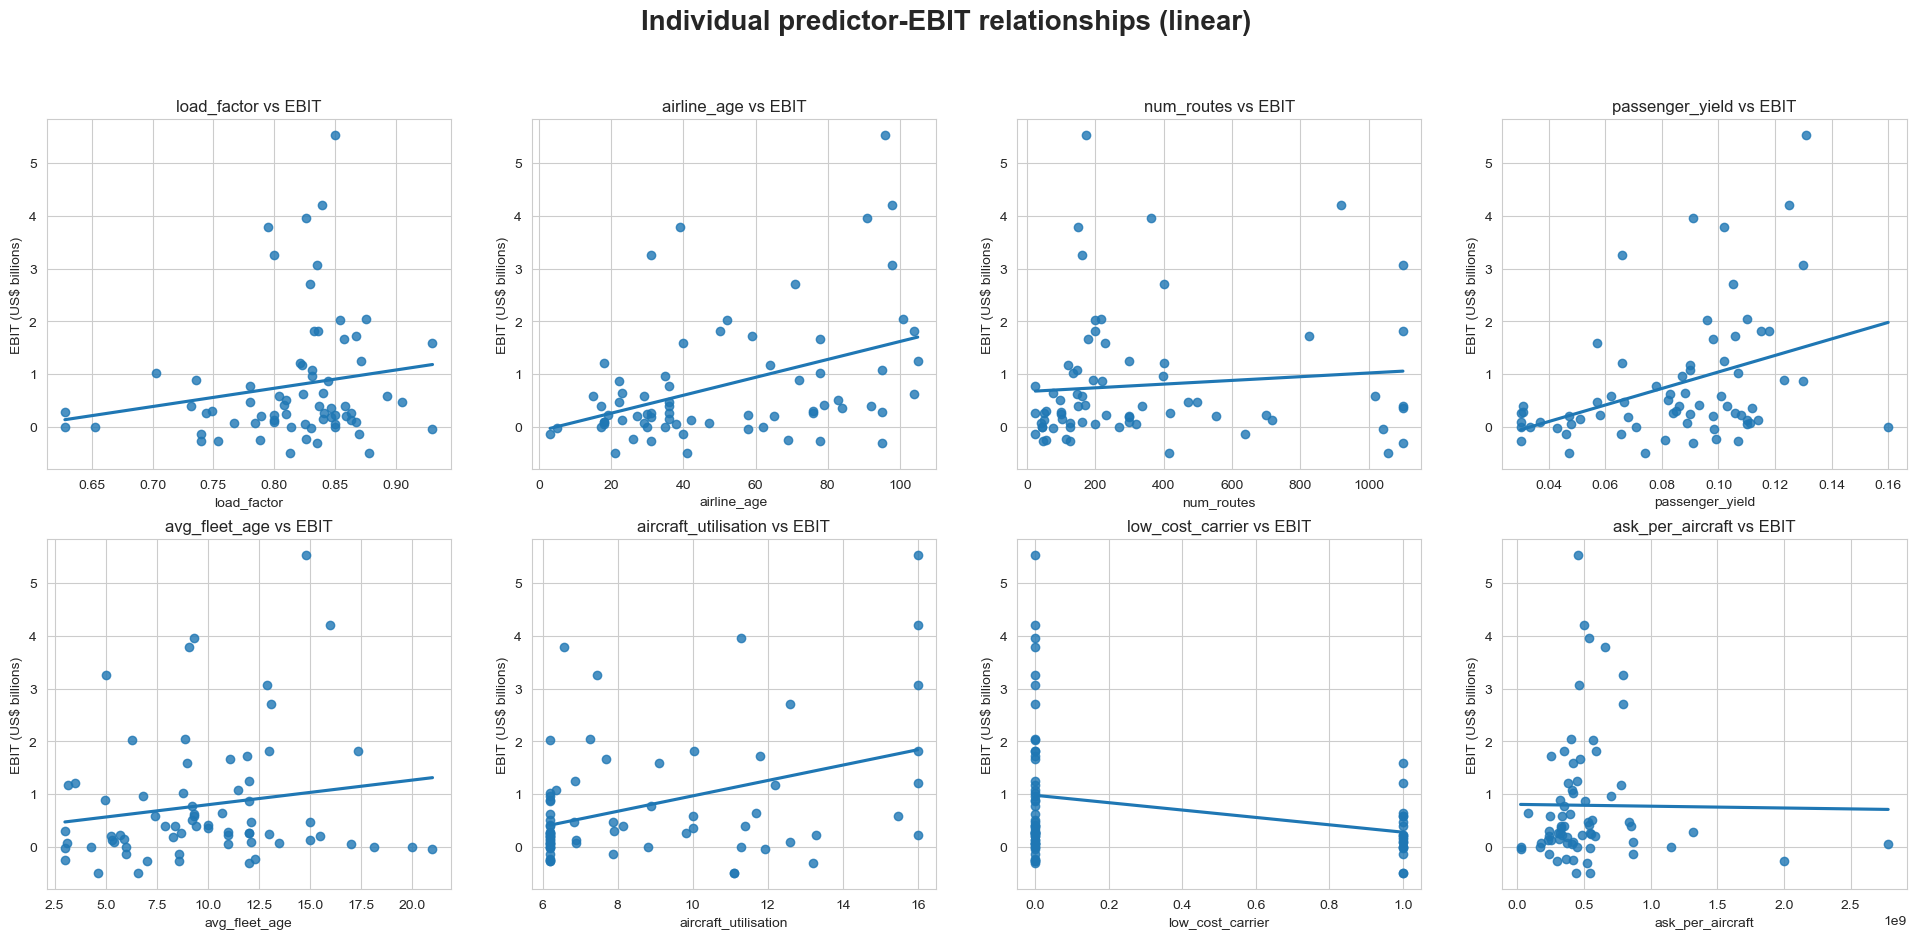

In [65]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(4*6, 2*5))
ax = ax.flatten()

for i, pred in enumerate(numeric_predictors):
    sns.regplot(x=X_obs[:,i], y=y[observed_ebit]/1000000000, ax=ax[i], order=1, ci=None)
    ax[i].set_title(f'{pred} vs EBIT')
    ax[i].set_xlabel(pred)
    ax[i].set_ylabel('EBIT (US$ billions)')

plt.suptitle('Individual predictor-EBIT relationships (linear)', weight='bold', fontsize=20, y=0.99)
plt.show()

I made a similar plot with quadratic and cubic fit lines:

/opt/anaconda3/lib/python3.12/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


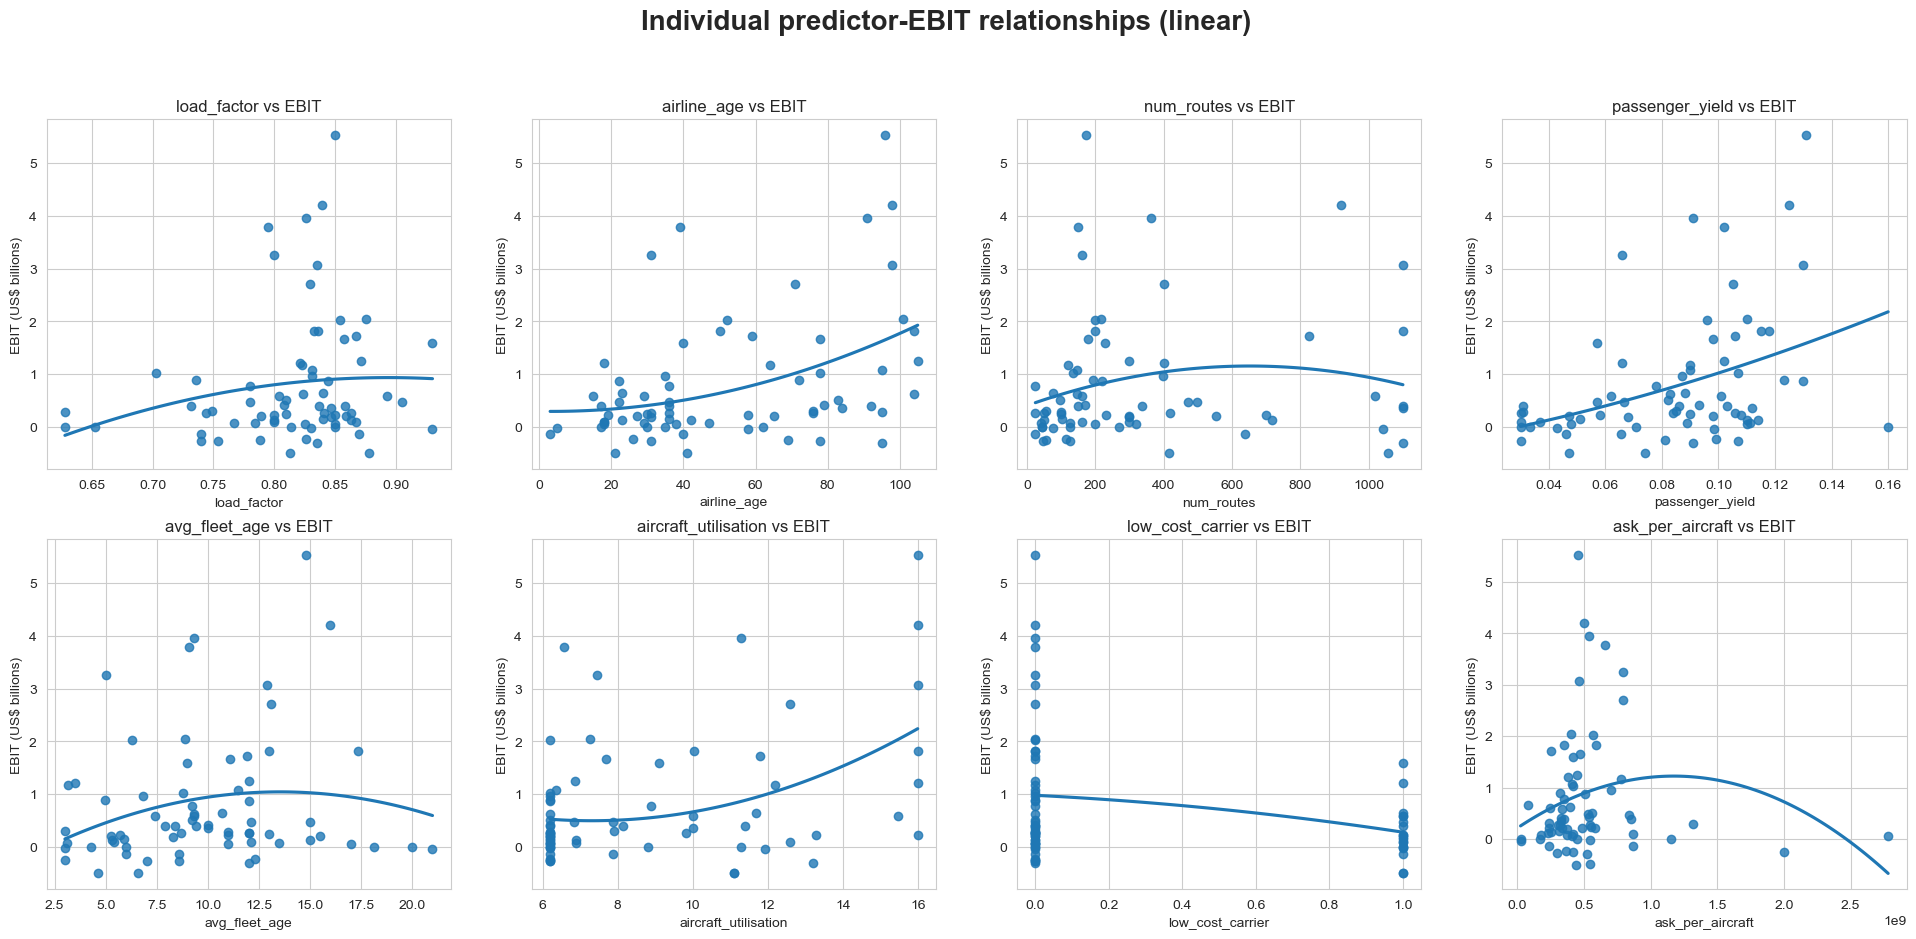

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(4*6, 2*5))
ax = ax.flatten()

for i, pred in enumerate(numeric_predictors):
    sns.regplot(x=X_obs[:,i], y=y[observed_ebit]/1000000000, ax=ax[i], order=2, ci=None)
    ax[i].set_title(f'{pred} vs EBIT')
    ax[i].set_xlabel(pred)
    ax[i].set_ylabel('EBIT (US$ billions)')

plt.suptitle('Individual predictor-EBIT relationships (linear)', weight='bold', fontsize=20, y=0.99)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


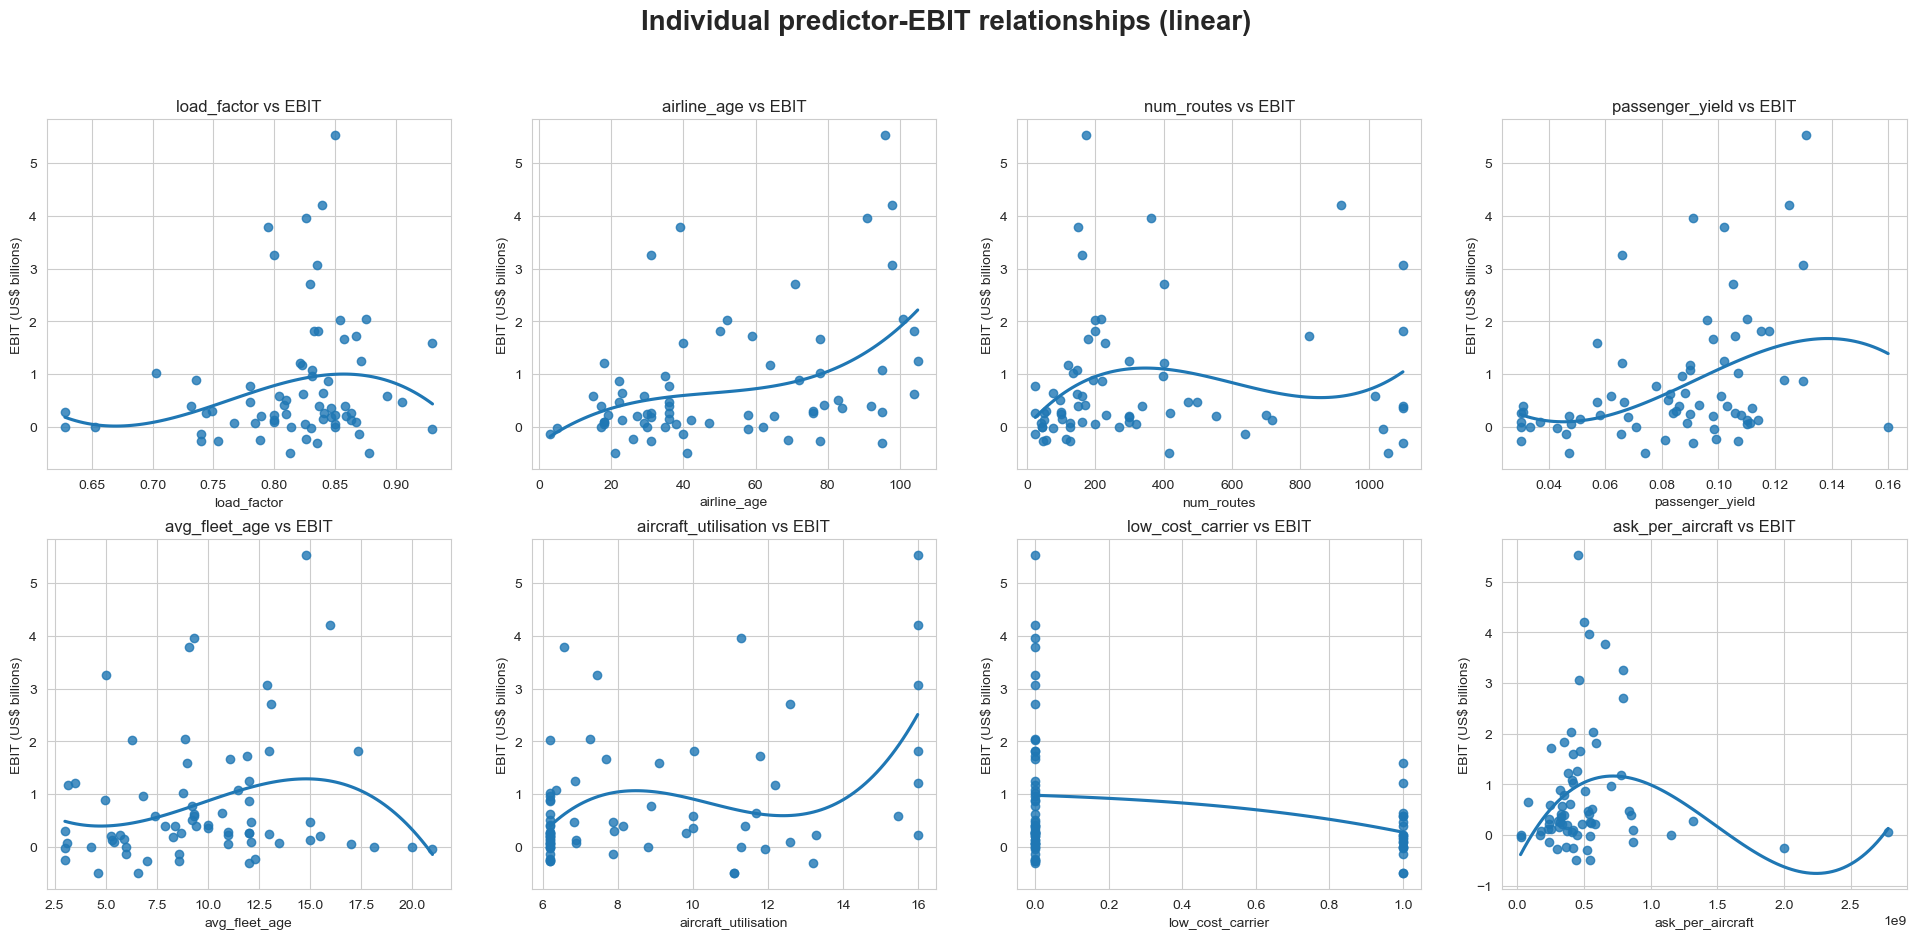

In [67]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(4*6, 2*5))
ax = ax.flatten()

for i, pred in enumerate(numeric_predictors):
    sns.regplot(x=X_obs[:,i], y=y[observed_ebit]/1000000000, ax=ax[i], order=3, ci=None)
    ax[i].set_title(f'{pred} vs EBIT')
    ax[i].set_xlabel(pred)
    ax[i].set_ylabel('EBIT (US$ billions)')

plt.suptitle('Individual predictor-EBIT relationships (linear)', weight='bold', fontsize=20, y=0.99)
plt.show()

Given the limited size of the data set (**70** observations), I needed to limit the total number of variables introduced into the model. I therefore defaulted to linear relationships unless the evidence of a nonlinear relationship was overwhelming.

- `load_factor` - I modelled this relationship as **linear** to capture the fact that EBIT was generally higher for airlines with higher load factors. Given that there is more data in the `0.80` to `0.90` load factor range, there will be a higher spread of EBIT values in this range, but still with an average of around $1 billion. Because there are only 3 observations in the `0.90` to `1.00` range, this is not enough evidence to suggest that EBIT in this range of load factor values is lower than in the `0.80` to `0.90` range (or that the relationship ceases to be linear), as suggested by the quadratic and cubic fit lines.

- `airline_age`, `passenger_yield`, and `aircraft_utilisation` - I also modelled these relationships as **linear** - there isn't sufficient evidence in any of these cases to suggest that the relationships are quadratic or cubic. Additionally, the quadratic line is not too dissimilar from the linear line, and the cubic line exhibits erratic behaviour in the boundary regions. **Aside**: The "fanning out" that we see in these plots indicates that [heteroscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity) may be an issue, and detecting and dealing with this is covered in the Model Evaluation section.

- `avg_fleet_age` - The data imply that airlines with younger fleets generally had lower EBIT values, with EBIT increasing somewhat for older fleets up to a point. Then, EBIT returns to zero for much older fleets (although there is limited data for average fleet ages of 17.5 years and older). Initially, I suspected that airlines with younger fleets had higher financing or leasing costs, which outweighed the fuel savings brought about by having a more efficient fleet, with this relationship holding only up to a point, after which savings from fuel efficiency would outweigh the increased costs, penalising airlines with older fleets. However, financing costs are **not** subtracted when calculating EBIT, and I was not too sure whether leasing costs are counted as financial costs or operating costs. Regardless, the apparent "curvature" in this relationship warrants a **quadratic** model.

- `low_cost_carrier` - this is a categorical variable, so the default relationship in this case is a **linear** one - this encodes the change in mean EBIT between *low-cost carriers* and *full-service carriers*.

- `num_routes` and `ask_per_aircraft`- These predictors have distributions that are heavily right-skewed (most observations are in the `0`-`400` range for `num_routes`, and the `0.0` to `1.0` range for ask_per_aircraft). I therefore performed log transformations on both of them, helping to make the data in both cases more suitable for a **linear** model. The log transformation "stretches out" the smaller, more common values and "compresses" the larger, rarer values. Another advantage is that it preserves nonnegativity:

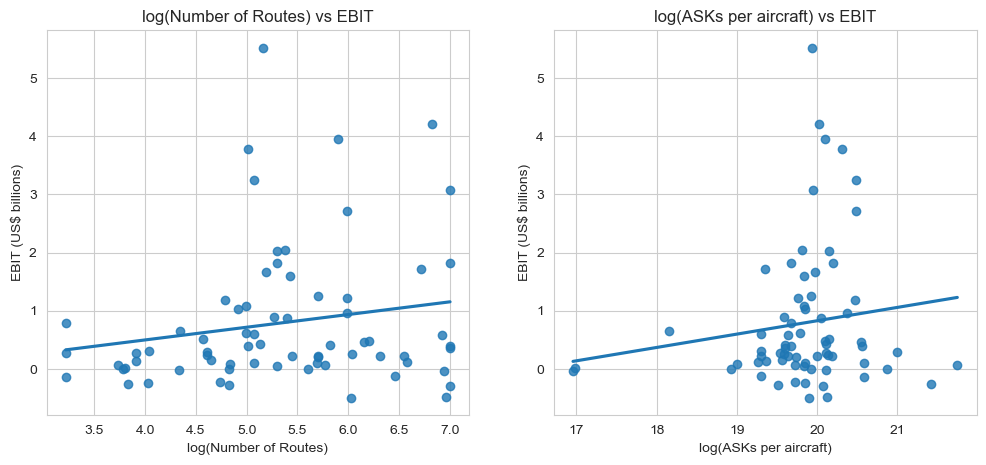

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(2*6, 1*5))
ax = ax.flatten()

sns.regplot(x=np.log(X_obs[:,2]), y=y[observed_ebit]/1000000000, ax=ax[0], order=1, ci=None)
ax[0].set_title('log(Number of Routes) vs EBIT')
ax[0].set_xlabel('log(Number of Routes)')
ax[0].set_ylabel('EBIT (US$ billions)')

sns.regplot(x=np.log(X_obs[:,7]), y=y[observed_ebit]/1000000000, ax=ax[1], order=1, ci=None)
ax[1].set_title('log(ASKs per aircraft) vs EBIT')
ax[1].set_xlabel('log(ASKs per aircraft)')
ax[1].set_ylabel('EBIT (US$ billions)')

plt.show()

The log transformation on `num_routes` made the data much more spread out, and it's clear that the relationship is best described by a straight line. The transformation did not work as well with `ask_per_aircraft` - the distribution of the data points (in the x direction) seems somewhat symmetrical, but most of the data points are clustered in the middle. There may be more sophisticated transformations that could deal with this, but for simplicity, I will stick with this transformation and fit a **linear** relationship to it.

#### FINAL SET OF PREDICTORS

My final set of predictors was:

- `load_factor`
- `airline_age`
- `log(num_routes)`
- `passenger_yield`
- `avg_fleet_age`
- `avg_fleet_age**2`
- `aircraft_utilisation`
- `low_cost_carrier`
- `log(ask_per_aircraft)`

bringing the total number of predictors to **9**, against a sample size of **70**, meaning an average of **7.8** observations per predictor.

A common rule-of-thumb for Ordinary Least Squares regression is (at minimum) 10 observations per predictor. 7.8 was thus on the lower side of what the literature generally recommends. This was especially problematic in this case because of the significant noise the data had as shown in the plots. I could have proceeded by eliminating some predictors to bring the ratio up to about 10, or regularising the coefficient estimates with Ridge or Lasso regression.

**Verdict**: I was interested in seeing how my model captures the relationships between EBIT and all the predictors I'd included; thus, I decided not to eliminate any predictors. Regularisation may have helped deal with the instability of the coefficient estimates, but would have also reduced the interpretability of the resulting model. I therefore proceeded with the full set of predictors and fit an OLS model, while remaining **cautious** in the interpretation of the resulting model and its metrics.

Let me update the data matrix with the final set of predictors.

In [69]:
numeric_predictors # the old list of predictors

['load_factor',
 'airline_age',
 'num_routes',
 'passenger_yield',
 'avg_fleet_age',
 'aircraft_utilisation',
 'low_cost_carrier',
 'ask_per_aircraft']

In [70]:
# create the final list of predictors
predictors = numeric_predictors[:]
predictors.insert(5, 'avg_fleet_age**2')
predictors[2] = 'log(num_routes)'
predictors[8] = 'log(ask_per_aircraft)'
predictors

['load_factor',
 'airline_age',
 'log(num_routes)',
 'passenger_yield',
 'avg_fleet_age',
 'avg_fleet_age**2',
 'aircraft_utilisation',
 'low_cost_carrier',
 'log(ask_per_aircraft)']

In [71]:
# update the data matrix (including observations with missing EBIT values)
X_new[:,2] = np.log(X_new[:,2])
X_new = np.insert(X_new, 5, X_new[:,4]**2, axis=1)
X_new[:,8] = np.log(X_new[:,8])
X_obs = X_new[observed_ebit] # the model will be built with X_obs (observations whose EBIT values are not missing)

In [72]:
# create the design matrix by adding an intercept column
X_obs = np.column_stack([np.ones((X_obs.shape[0],)), X_obs])

## Model Building

After deciding on my final set of predictors (and performing all the required transformations on the predictors), I computed the OLS estimate of the coefficients.

#### QUICK REFRESHER ON LINEAR REGRESSION:

The linear model assumes that the relationship between the predictors and the response is linear. In other words:
$$
\boldsymbol{y} = X\boldsymbol{\beta} + \boldsymbol{\epsilon}
$$
where $ X:n\times (p+1) $ is the data matrix with an intercept column, and $\boldsymbol{\epsilon} \sim \mathcal{N}(\boldsymbol{0}, \sigma^2 \boldsymbol{I})$ is an error term.

It can be shown that the Ordinary Least Squares estimate, i.e. the estimate of $\boldsymbol{\beta}$ that minimises the sum of squares of differences between the observed response values and the regression surface, is:
$$
\boldsymbol{\hat{\beta}} = (X^\top X)^{-1}X^\top \boldsymbol{y}$$

I computed the OLS estimate using the design matrix `X_obs`.

#### COMPUTING $\boldsymbol{\hat{\beta}}$ AND BUILDING THE MODEL

In [73]:
# isolate the observed response values
y_obs = y[observed_ebit]

# compute the OLS estimate
beta_hat = np.linalg.inv(X_obs.T@X_obs)@X_obs.T@y_obs

## Model Evaluation

#### COMPUTING REGRESSION AND MODEL FIT STATISTICS

$R^2 = 1 - \frac{RSS}{TSS}$ measures the proportion of the variation in the response (EBIT) that is explained by our model.

[   where $RSS = (\boldsymbol{y} - X\boldsymbol{\hat{\beta}})^\top (\boldsymbol{y} - X\boldsymbol{\hat{\beta}}) \quad$ and $ \quad TSS = (\boldsymbol{y} - \bar{y}\boldsymbol{1})^\top (\boldsymbol{y} - \bar{y}\boldsymbol{1})$    ]

In [74]:
rss = (y_obs - X_obs@beta_hat).T@(y_obs - X_obs@beta_hat)
tss = (y_obs - np.mean(y_obs)*np.ones((y_obs.shape[0]))).T@(y_obs - np.mean(y_obs)*np.ones((y_obs.shape[0])))
r_squared = 1 - rss/tss
r_squared

0.4267758808053982

$R^2_{adj} = 1 - \frac{RSS/(n-p-1)}{TSS/(n-1)}$ accounts for the number of predictors in the model, making it better suited for comparison of different models. $R^2$ always increases when you add more predictors to the model, but $R^2_{adj}$ strikes a balance between predictive accuracy and model complexity as measured by number of predictors.

In [75]:
n = 70 # number of observations
p = 9 # number of (non-intercept) predictors
adj_r_squared = 1 - (rss/(n-p-1))/(tss/(n-1))
adj_r_squared

0.3407922629262079

To test the overall significance of the model (i.e. if at least one of the predictors has a statistically significant relationship with the response), I performed an F-test, which makes use of the F-statistic:

$$
F_{stat} = \frac{(TSS - RSS)/p}{RSS/(n - p - 1)}
$$

In [76]:
f_stat = ((tss-rss)/(p))/(rss/(n-p-1))
f_stat

4.963455729497588

This statistic has an $F_{p,\:n-p-1}$ distribution under the null hypothesis. The p-value associated with this F-stat value is difficult to compute manually using only `numpy`. Using external software, I calculated this value to be **0.00005453**. This is (very) statistically significant at a 5% significance level.

To test the significance of each predictor (and the intercept) individually, I performed a t-test, which makes use of the t-statistic:
$$
t_i = \frac{\hat{\beta_i}}{\sqrt{\hat{Var}(\hat{\beta_i})}}
$$

where $\hat{Var}(\hat{\beta_i})$ is the $i^{th}$ diagonal element of $\hat{Cov}(\hat{\beta}) = \hat{\sigma}^2 (X^\top X)^{-1}$, where $\hat{\sigma}^2 = \frac{RSS}{n-p-1}$. This statistic has a $t_{n-p-1}$ distribution under the null hypothesis.

In [77]:
# estimate the variance of the error terms
sigma_2_hat = rss/(n-p-1)

# estimate the covariance of the coefficient estimate
cov_beta_hat = sigma_2_hat*np.linalg.inv(X_obs.T@X_obs)

# compute the t-statistics
t_stats = []
for i in range(p+1):
    t_stats += [beta_hat[i]/np.sqrt(cov_beta_hat[i,i])]
t_stats

[-3.010774767679231,
 1.7445667506096507,
 1.416426361117445,
 -1.7146539893685717,
 1.5981448943390626,
 0.24090748238984575,
 -0.05928769681665674,
 3.239595372350885,
 -1.1707685319293157,
 2.232394843244015]

Computing the p-values associated with these t-statistics using only `numpy` would be a significant undertaking. Using external software, I obtained these p-values:

In [78]:
t_p_values = [0.00380883, 0.08618091, 0.16182173, 0.09157007, 0.11526427, 0.81044815, 0.95291999, 0.00195359, 0.24632077, 0.02933326]

#### INTERPRETING REGRESSION AND MODEL FIT STATISTICS

I will now output all the regression and model fit statistics computed in the previous section. This output is similar to what libraries such as `stats_models` would output.

In [79]:
print(f'R-squared: {r_squared}')
print(f'Adj. R-squared: {adj_r_squared}')
print(f'F-statistic: {f_stat}')
print(f'F-statistic p-value: 0.00005453')
print()
print(f'{"Predictor":<20} {"Coef.":>15} {"t-stat":>15} {"p-value":>15}')
print('-' * 68)
predictors = ['intercept'] + predictors
for i in range(p+1):
    print(f'{predictors[i]:<20} {beta_hat[i]:>15.4e} {t_stats[i]:>15.4f} {t_p_values[i]:>15.4f}')


R-squared: 0.4267758808053982
Adj. R-squared: 0.3407922629262079
F-statistic: 4.963455729497588
F-statistic p-value: 0.00005453

Predictor                      Coef.          t-stat         p-value
--------------------------------------------------------------------
intercept                -1.3104e+10         -3.0108          0.0038
load_factor               4.3265e+09          1.7446          0.0862
airline_age               7.7421e+06          1.4164          0.1618
log(num_routes)          -2.6973e+08         -1.7147          0.0916
passenger_yield           8.2314e+09          1.5981          0.1153
avg_fleet_age             3.2273e+07          0.2409          0.8104
avg_fleet_age**2         -3.7825e+05         -0.0593          0.9529
aircraft_utilisation      1.5948e+08          3.2396          0.0020
low_cost_carrier         -4.9597e+08         -1.1708          0.2463
log(ask_per_aircraft)      4.6289e+08          2.2324          0.0293


**R_squared**: An $R^2$ value of **0.426776** indicates that this model explains about **42.7%** of the variation in the response. This would be on the low side for many science/engineering-based analyses, but considering that this model was based on only 70 observations, and considering the noisiness exhibited in many of the plots, explaining 43% of the variance is probably the best we could hope for.

**Adjusted R_squared**: The $R^2_{adj}$ value drops to **34.1%**. This significant drop indicates that some predictors do not contribute much to the model's predictive power and are only adding noise to the model. I will discuss this further shortly.

**F-statistic p-value**: A p-value of **0.00005453** indicates that we must reject the null hypothesis that there is no relationship between the predictors and the response. This means that our model is statistically significant (at a 5% significance level) and performs better than random chance.

**Individual coefficient p-values**: The results in this section are interesting. At a 5% significance level, all but two variables (including the intercept) are not statistically significant. The especially insignificant predictors are `avg_fleet_age` and `avg_fleet_age**2`, with p-values of **0.8104** and **0.9529**, respectively. It may be these predictors that are causing the significant drop in R-squared to Adj. R-squared.

The cause of this issue is clear: a **small sample size**. This has the effect of reducing the hypothesis tests' power, meaning that even if there is a statistically significant effect, the t-test may not detect it with such a small sample size. I will therefore keep all the predictors in the model, but note this result.

#### VERIFYING MODEL ASSUMPTIONS: HOMOSCEDASTICITY, NORMALITY OF REDISUALS

To verify homoscedasticity (constant variance of residuals across the predicted values), I made a residual plot. This plot displays the residuals at each observed EBIT value.

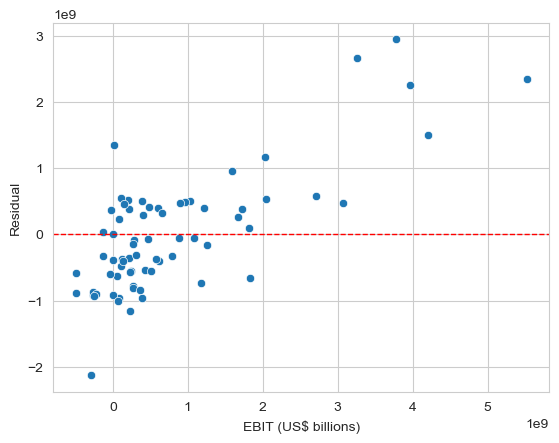

In [80]:
residuals = y_obs - X_obs@beta_hat
sns.scatterplot(x=y_obs, y=residuals)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('EBIT (US$ billions)')
plt.ylabel('Residual')
plt.show()

Note that, for moderate EBIT values between -\\$500 million and \\$2 billion, the variance of the residuals is approximately constant, and the residuals are centred at 0. But for higher, outlier EBIT values, the residuals are high and positive. This may be due to the right-skewness of the response - most EBIT values are in the aforementioned range, but a few outlier values are significantly higher than the rest, in the \\$3 billion to \\$6 billion range.

I also constructed a QQ-plot to test for normality of the residuals:

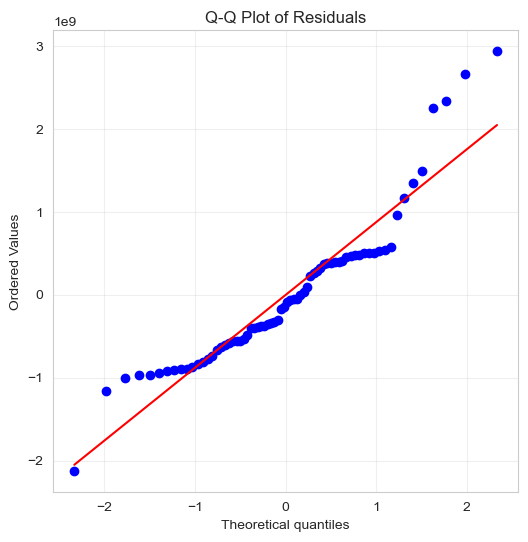

In [81]:
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True, alpha=0.3)
plt.show()

The QQ-plot indicates that the more common EBIT values in the centre mostly follow a normal distribution (as well as we can expect for a 70-observation data set). However, the observed quantiles begin to deviate significantly from the theoretical normal quantiles for outlier values - EBIT values below about -\\$750 million and above about \\$500 million.

These two plots, the QQ-plot and the residual plot, indicate that the variance of the residuals is generally not constant, and the residuals are generally not normally distributed. A variance-stabilising transform on the response (a log transformation being the most common) could deal with both these issues. However, because EBIT can be both positive and negative, a log transformation is not suitable in our context because the logarithm is defined only for **nonnegative** values. The other possible transformations are quite complicated, as we'd have to somehow account for the negative values.

I will therefore leave the model as it is, but note that the assumptions about normality of residuals and homoscedasticity are violated to some extent. The normality assumption does not affect the actual estimated coefficients - they only affect the t-tests and associated p-values - this goes some way in explaining why most of the predictors are seemingly statistically insignificant. I believe that the residuals in this model are homoscedastic for non-outlier response values.

The [Gauss-Markov theorem](https://en.wikipedia.org/wiki/Gauss–Markov_theorem), on which our use of the OLS estimator is based, requires the assumptions of linearity, no (perfect) multicollinearity (which our transformations in the [Feature Engineering](#Feature-Engineering) section address), and homoscedasticity.

#### PREDICTING OBSERVATIONS WITH MISSING EBIT VALUES

Recall that in the model building stage I excluded observations whose EBIT values were not observed. After building my model, I used my fitted model to predict these EBIT values. While these predictions are not of much use to us (since the actual EBIT values are unobserved and cannot be compared against), they do demonstrate that the model produces "reasonable" EBIT values for unseen data.

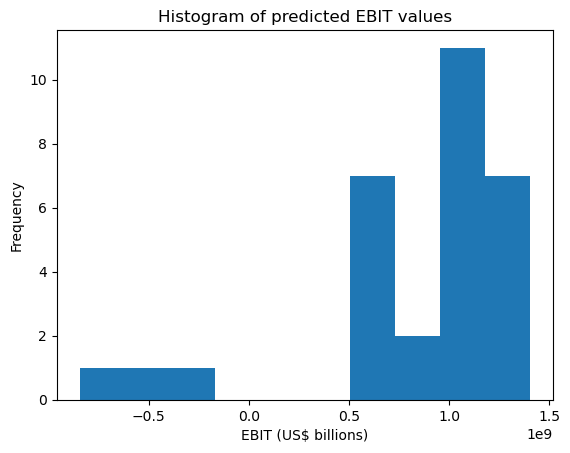

In [203]:
X_unobs = X_new[~observed_ebit]
X_unobs = np.column_stack([np.ones((X_unobs.shape[0],)), X_unobs])
y_unobs_hat = X_unobs@beta_hat
plt.hist(y_unobs_hat)
plt.xlabel('EBIT (US$ billions)')
plt.ylabel('Frequency')
plt.title('Histogram of predicted EBIT values')
plt.show()

The EBIT values seem reasonable - they all fall in the typical range observed for most airlines.

## Results

To reiterate (for any readers that skipped the previous sections): I used an **Ordinary Least Squares (OLS) Regression** model to investigate the key factors that influenced airline profit (as measured by earnings before interest and taxes (EBIT)) in the 2022/23 financial year. This period is significant because it was the first full financial year not affected by COVID restrictions/lockdowns.

The factors I included in my analysis were:
- Load factor *(percentage of available seats that were filled by paying passengers)*
- Airline age
- Number of routes
- Passenger yield *(the average amount of money an airline makes for each kilometre a paying passenger travels)*
- Available Seat Kilometres *(total capacity; total number of seats on a plane $\times$ total number of kilometres flown)*
- Average Fleet Age
- Fleet size *(total number of aircraft operated by the airline)*
- Aircraft Utilisation Rate *(average number of hours each aircraft flies per day)*

As part of my analysis, I created new factors that were functions of some original factors to create factors that I felt "made more sense", and to reduce the extent to which some factors were related to others - in a sense, reducing redundancy. I also performed transformations on some predictors, either to capture non-linear relationships or to "unskew" factors that I felt were too right-skewed.

The results of this regression analysis were as follows:

In [47]:
print(f'R-squared: {r_squared}')
print(f'Adj. R-squared: {adj_r_squared}')
print(f'F-statistic: {f_stat}')
print(f'F-statistic p-value: 0.00005453')
print()
print(f'{"Predictor":<20} {"Coef.":>15} {"t-stat":>15} {"p-value":>15}')
print('-' * 68)
for i in range(p+1):
    print(f'{predictors[i]:<20} {beta_hat[i]:>15.4e} {t_stats[i]:>15.4f} {t_p_values[i]:>15.4f}')

R-squared: 0.4267758808053982
Adj. R-squared: 0.3407922629262079
F-statistic: 4.963455729497588
F-statistic p-value: 0.00005453

Predictor                      Coef.          t-stat         p-value
--------------------------------------------------------------------
intercept                -1.3104e+10         -3.0108          0.0038
load_factor               4.3265e+09          1.7446          0.0862
airline_age               7.7421e+06          1.4164          0.1618
log(num_routes)          -2.6973e+08         -1.7147          0.0916
passenger_yield           8.2314e+09          1.5981          0.1153
avg_fleet_age             3.2273e+07          0.2409          0.8104
avg_fleet_age**2         -3.7825e+05         -0.0593          0.9529
aircraft_utilisation      1.5948e+08          3.2396          0.0020
low_cost_carrier         -4.9597e+08         -1.1708          0.2463
log(ask_per_aircraft)      4.6289e+08          2.2324          0.0293


Keeping all other factors fixed (keeping in mind that these results are specific to the 2022/23 financial year):

- When **load factor** was increased from 0 to 1, the expected change in an airline's profit (as measured by EBIT) was +\\$4.32 billion. In other words, a one percentage-point increase in load factor was associated with an increase in EBIT of \\$43.2 million.
- Each additional **year of age** resulted in an airline earning \\$7 million more.
- A 1% increase in an airline's **number of routes** was associated with a decrease in profit of $\frac{269730000}{100} \approx \$2.7\:\text{million}$. Note that a multiplicative relationship was found to be a better model than an additive one. It must be noted that, when regressing profit onto each predictor individually, the relationship was found to be positive, i.e. a 1% increase was found to increase profit. This contradiction implies that there is a third, confounding factor that I've included in the model that, when controlled for, results in a negative relationship between profit and number of routes. I take this result to indicate that **number of routes** is not a strong predictor of profit.
- A 1 US cent increase in **passenger yield** (revenue per passenger per kilometre) was associated with an increase in profit of $\frac{8.2314\:billion}{100} \approx \$82.3\: million$.
- The negativity of the coefficient estimate of `avg_fleet_age**2` implies that an airline's averge fleet age had an inverted U-shaped relationship with profit, with profit increasing with average age until the age $-\frac{32273000}{2\times-378250} \approx 42.66 \:\text{years}$, after which older fleets were associated with lower profit.
- An extra block hour of aircraft utilisation was associated with an increase in profit of about \\$159 million.
- A low-cost carrier earned, on average, about \\$462 million less in profit than a full-service carrier.
- A 1% increase in **capacity per aircraft**, as measured by **Available Seat Kilometres (ASKs) per aircraft**, was associated with a $\frac{462890000}{100} \approx \$4.6\:million$ increase in profit. As with the number of routes, a multiplicative relation was found to be a better model for this relationship than an additive one. This is another measure of aircraft utilisation.

#### KEY FINDINGS

**AIRLINES THAT FLEW FULLER PLANES WERE MORE PROFITABLE**: An airline that managed to fill one extra seat per hundred seats earned about \\$43.2 million more in profit. It must be noted that this is after controlling for revenue per passenger per kilometre (passenger yield) and whether the airline was a low-cost carrier or full-service carrier.

**AN AIRLINE'S NUMBER OF ROUTES WAS FOUND NOT TO BE A STRONG PREDICTOR OF PROFIT**: A 1% change in number of routes was found to decrease profit only by a couple of millions of dollars (keeping the other factors in the model constant). In fact, an initially positive relationship was found to change to a negative one after controlling for these other factors. Factors in the model that may have confounded the initial relationship are load factor (indicating that airlines with more routes may actually have lower average load factors), and aircraft utilisation (indicating that airlines that overutilised their aircraft may have experienced lower average load factors). As the world was still recovering from COVID in FY 2022/23, it was perhaps the case that certain destinations (e.g. more "ourdoorsy" vacation destinations) were more popular than others, and airlines that better capitalised on this by focusing on those routes could overcome the disadvantage of maintaining a smaller route network than larger airlines.

**LOW-COST CARRIERS WERE LESS PROFITABLE COMING OUT OF COVID THAN FULL-SERVICE CARRIERS**: It is important to note that this does **not** imply that full-service carriers recovered faster than low-cost carriers. This model only considered absolute profit levels and did **not** control for pre-pandemic profit levels. It may simply be the case that low-cost carriers have generally earned lower profit than full-service carriers on average, and actually recovered to their pre-pandemic profit levels faster than full-service carriers. Unfortunately, I cannot make this determination because pre-pandemic profit was not included as a predictor.

**LEGACY AIRLINES EARNED HIGHER PROFITS COMING OUT OF COVID**: Controlling for the other factors in the model (in particular, whether the airline was a low-cost carrier, and the airline's size as measured by the number of routes), older airlines were more profitable than legacy airlines. However, the variance in profit seen in the dataset was quite high for most older airlines, meaning the generalisability of this result is perhaps diminished for much older airlines.

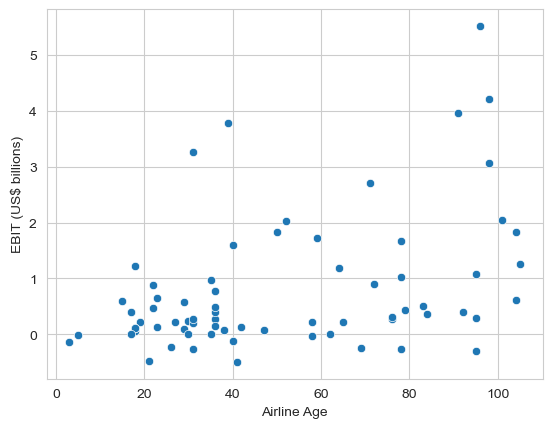

In [71]:
sns.scatterplot(y=y_obs/1000000000, x=X_obs[:,2])
plt.xlabel('Airline Age')
plt.ylabel('EBIT (US$ billions)')
plt.show()

**AIRLINES THAT WERE ABLE TO GET AN ADDITIONAL FLIGHT HOUR OUT OF EACH AIRCRAFT PER DAY COULD INCREASE PROFIT CONSIDERABLY**: An airline that used each of its aircraft for one extra hour each day earned about $160 million extra in profit. However, it must be noted that **most** values for this predictor were missing in the dataset (especially for airlines that had outlier profit values) and had to be imputed using matrix completion. This result depends heavily on the matrix completion method working properly, and the assumptions it relies on ( particularly, the degree of missingness) being satisfied.

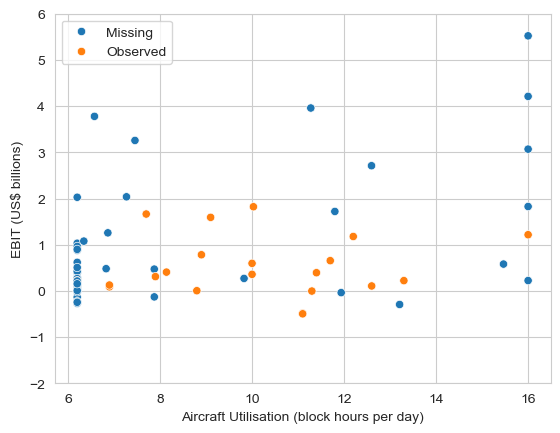

In [79]:
ax = sns.scatterplot(x=X_new[:,6], y=y/1000000000, \
                     hue=["Observed" if not np.isnan(val) else "Missing" for val in X[:,7]])
ax.set(xlabel='Aircraft Utilisation (block hours per day)', ylabel = 'EBIT (US$ billions)', yticks=range(-2,7))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### LIMITATIONS

1. **This analysis does not account for all variables that could influence profit**: Results should therefore be seen as associational and not causal. There may be uncontrolled factors that confound the supposed relationships found in the previous section. For example, airline region was not included as a predictor, meaning results aggregated globally may not generalise to all regions.

2. **The sample size was severely limited**: Analysis based on a sample of 70 airlines may not generalise to the population of more than a thousand airlines globally. Given the number of predictors modelled, the variance of the model is likely high (i.e. the model may give radically different results when training on a different sample of 70 airlines from the population). Additionally, this sample was **not random** - it was sampled based on region and airline size.

3. **Several assumptions on which the OLS regression model rely may have been violated**: In particular, the assumption of **homoscedasticity** (the model's errors are consistently spread out across all profit levels) and the **normality of errors** assumption (the model's errors follow a normal distribution) are not entirely satisfied by the data.

4. **Financial reporting periods do not align perfectly**: Some airlines report financials based on the calendar year, while others use a fiscal year that, for example, may start in July and end in June. I used the reports closest to the 2022/23 period, but some slight inconsistencies remained.

#### CONCLUSION

To summarise: **Load factor** and **aircraft utilisation** were very strong drivers of profit, although it must be noted that the prevalence of missing values for the latter makes its result less reliable. Additionally, full-service and legacy airlines were more profitable coming out of the pandemic than less established or low-cost airlines. However, this result does not imply that full-service or legacy airlines recovered to pre-pandemic profit levels faster than low-cost airlines as pre-pandemic profit was not controlled for in this analysis.

The results of this analysis therefore suggest that operational efficiency (particularly in how often planes flew and how full they were) may have been more important than airline size or type in determining profit. Future analysis may benefit from a larger sample size or more sophisticated techniques such as regularisation or tree-based methods.

*Darren Dube - Data Science student at Stellenbosch University. Catch me on [LinkedIn](https://linkedin.com/in/darrendube)*